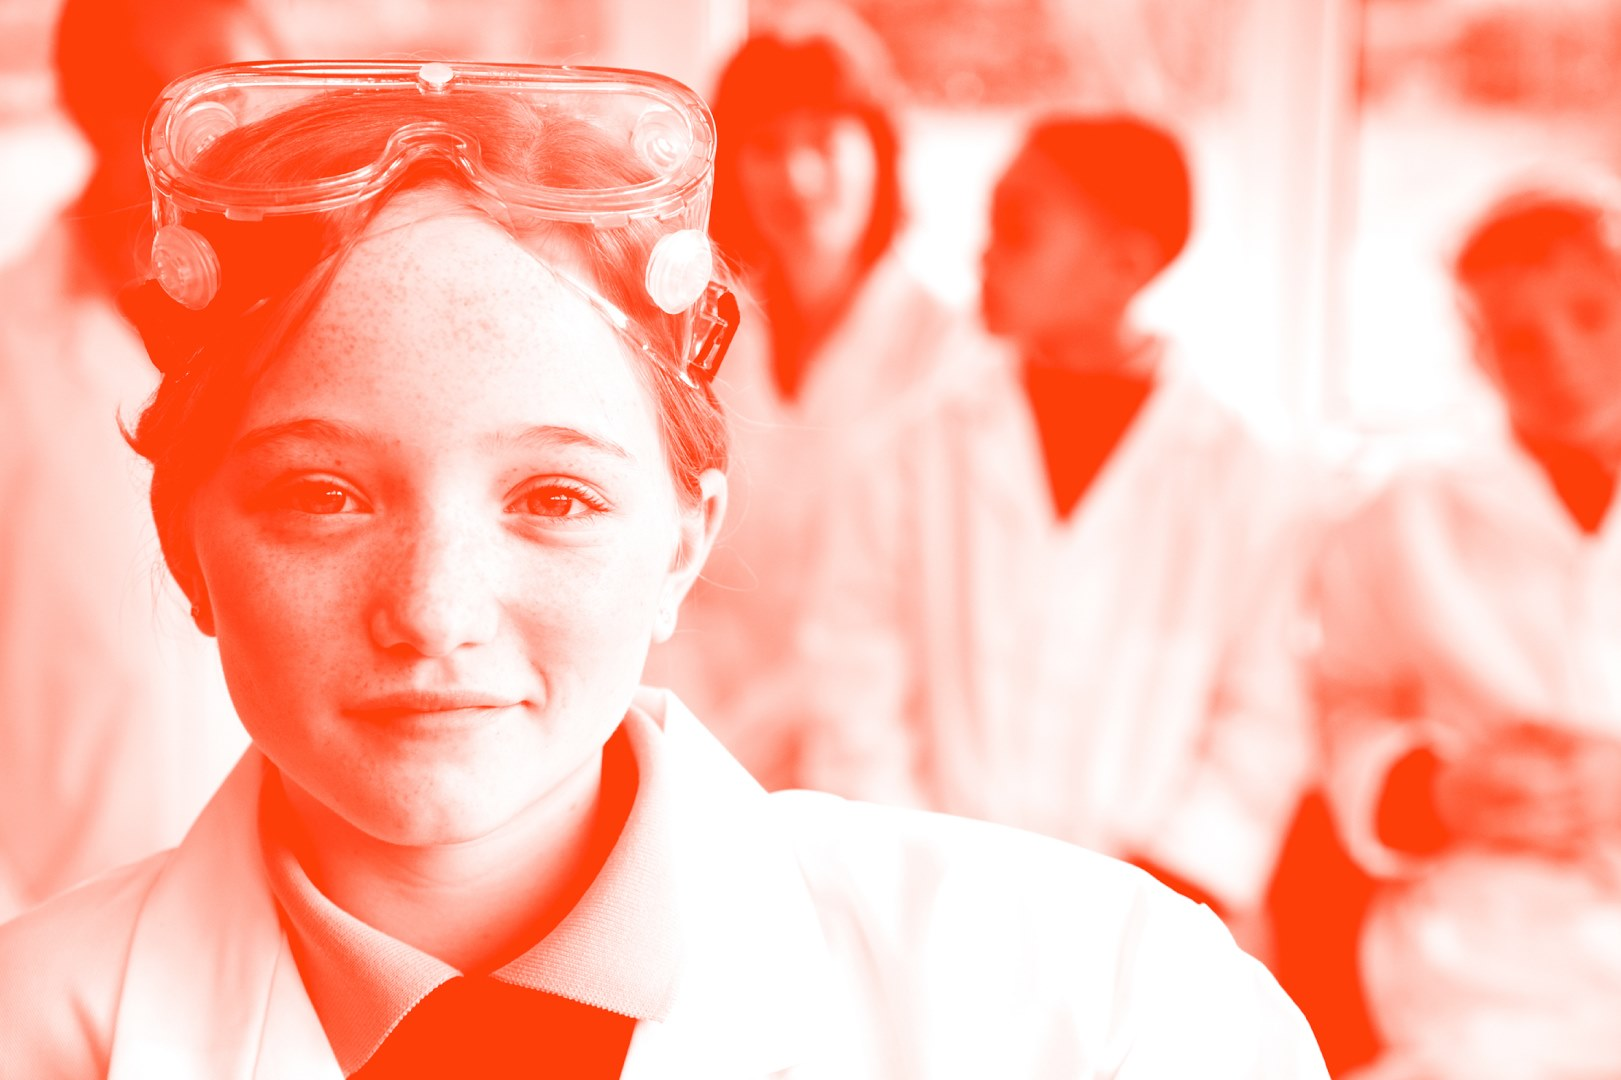

# Prototype Score-Predicting Model Based on Portuguese Secondary Student Performance Data

This notebook contains the code of a prototype ML-based score-predicting feature, designed for the main product of Focus Project as part of my internship. The dataset includes attributes such as past student grades, demographic, social, and school related factors. After performing some basic visualisations, data pre-processing and feature engineering, the data was modelled under binary/five-level classification and regression tasks to predict the students' final scores. Some models' hyper-parameters were fine-tuned to optimise performance, whereas other models with already competitive results did not undergo this procedure to prioritise computational time over performance. Towards the end of this notebook, to tackle class imbalance, the SMOTE (Synthetic Minority Oversampling Technique) was performed, yielding more competitive results.

I am still learning everyday and I am always open to new ideas that can help me improve my code, therefore, if you have any feedback, queries or concerns regarding this notebook, please feel free to email me at aryanmsr@gmail.com.

- Link to dataset: https://archive.ics.uci.edu/ml/datasets/Student+Performance
- Link to the original research paper from which this notebook is based on: http://www3.dsi.uminho.pt/pcortez/student.pdf


## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

## Importing the dataset

In [2]:
dataset = pd.read_csv("student-por.csv")

In [3]:
dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
dataset.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10
648,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,4,10,11,11


As we can see from the dataset above, all of the columns apart from the last one (G3) represent the features present in our dataset. The columns G3 represents the scores of students in their final examinations, and is the main variable we are trying to predict.

## Creating Modified Labels 

Now that we have imported the dataset, we must create some new labels that will further help us down the line in our analysis, especially in our classification tasks. Particularly, we will create the following new labels:

- Pass/Fail
- Five-Level Grade Label Encoded
- Five-Level Grade Letter

Pass/Fail simply indicates whether the student passed or failed their final exam. Students fail if they receive a score below 10 out of 20. "Five-Level Grade Label Encoded" categorises the final grades in five categories. 1 indicates a score of 16 or above out of 20, 2 indicates a score of 14 or 15, 3 indicates a score of 12 or 13, 4 indicates a score of 10 of 11, and 5 indicates a score of 9 or below. 1,2,3,4,5 correspond to A,B,C,D,F respectively. The "Five-Level Grade Letter" columns represents the letter representations of the column "Five-Level Grade Label Encoded".
All three labels are based on the "G3" column.


In [5]:
grades_pass_fail = []
grades_erasmus_label_encoded = []
grades_erasmus = []

for index, row in dataset.iterrows():
    if row['G3'] >= 10:
        grades_pass_fail.append(1) #pass
    elif row['G3'] < 10:
        grades_pass_fail.append(0) #fail
for index, row in dataset.iterrows():
    if row['G3'] >= 16:
        grades_erasmus_label_encoded.append(1) #A
        grades_erasmus.append('A') 
    elif row['G3'] == 15 or row['G3'] == 14:
        grades_erasmus_label_encoded.append(2) #B
        grades_erasmus.append('B')
    elif row['G3'] == 12 or row['G3'] == 13:
        grades_erasmus_label_encoded.append(3) #C
        grades_erasmus.append('C')
    elif row['G3'] == 10 or row['G3'] == 11:
        grades_erasmus_label_encoded.append(4) #D
        grades_erasmus.append('D')
    elif row['G3'] <= 9:
        grades_erasmus_label_encoded.append(5) #F   
        grades_erasmus.append('F')
        
grades_pass_fail_series = pd.Series(grades_pass_fail)
grades_erasmus_label_encoded_series = pd.Series(grades_erasmus_label_encoded)
grades_erasmus_series = pd.Series(grades_erasmus)
dataset["Pass/Fail"] = grades_pass_fail_series
dataset["Five-Level Grade Label Encoded"] = grades_erasmus_label_encoded_series
dataset["Five-Level Grade Letter"] = grades_erasmus_series

In [6]:
dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,Pass/Fail,Five-Level Grade Label Encoded,Five-Level Grade Letter
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,1,3,4,0,11,11,1,4,D
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,1,3,2,9,11,11,1,4,D
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,3,3,6,12,13,12,1,3,C
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,1,5,0,14,14,14,1,2,B
4,GP,F,16,U,GT3,T,3,3,other,other,...,1,2,5,0,11,13,13,1,3,C


In [7]:
dataset.tail()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,Pass/Fail,Five-Level Grade Label Encoded,Five-Level Grade Letter
644,MS,F,19,R,GT3,T,2,3,services,other,...,1,2,5,4,10,11,10,1,4,D
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,1,1,1,4,15,15,16,1,1,A
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,5,6,11,12,9,0,5,F
647,MS,M,17,U,LE3,T,3,1,services,services,...,3,4,2,6,10,10,10,1,4,D
648,MS,M,18,R,LE3,T,3,2,services,other,...,3,4,5,4,10,11,11,1,4,D


We will now split the dataset into two parts - X & y. X represents the independent variables and y represents the dependent variable.

In [8]:
X = dataset.iloc[:, :-4].values #All columns until G3
y = dataset.iloc[:, -4].values #Column G3

In [9]:
print(X)

[['GP' 'F' 18 ... 4 0 11]
 ['GP' 'F' 17 ... 2 9 11]
 ['GP' 'F' 15 ... 6 12 13]
 ...
 ['MS' 'F' 18 ... 6 11 12]
 ['MS' 'M' 17 ... 6 10 10]
 ['MS' 'M' 18 ... 4 10 11]]


In [10]:
print(y)

[11 11 12 14 13 13 13 13 17 13 14 13 12 13 15 17 14 14  7 12 14 12 14 10
 10 12 12 11 13 12 11 15 15 12 12 11 14 13 12 12 10 11 15 10 11 11 13 17
 13 12 13 16  9 12 13 12 15 16 14 16 16 16 10 13 12 16 12 10 11 15 11 10
 11 14 11 11 11 13 10 11 12  9 11 13 12 12 11 15 11 10 11 13 12 14 12 13
 11 12 13 13  8 16 12 10 16 10 10 14 11 14 14 11 10 18 10 14 16 15 11 14
 14 13 13 13 11  9 11 11 15 13 12  8 11 13 12 14 11 11 11 15 10 13 12 11
 11 10 10 14  9 11  9 13 11 13 11  6 12 10 11 13 11  8 11  0 10 13 11 13
  8 10 11 11  1 10  9  8 10  8  8  8 11 18 13 17 10 18 10 13 15 11 14 10
 11 13 11 13 17 14 16 14 11 16 14 10 13 12 12 10 12 16 14 12 16 11 15 12
 15 13 13  8 12 15 13 12 12 12 13 11 11 15 10 10 13 13 11 12 14 10 16  8
 17 11 11 16 12 13 13 14  9 12 16 10 13 10 10  7  8  9 15 10 11 13  8  8
 10 15 14 15 12 15 15 12 15 11 10 11 16 11 13  5 10 11  7 10  6 12 13 10
 13 17 11 11 14 14 13 14 16 10 12 12 15 11 12 13 13  9 16 14 12 14 10 12
 16 13 18 15 16 12 10 12 13 15 10 10 11 10 13 18 13

## Data Visualizations

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Grades - G3')

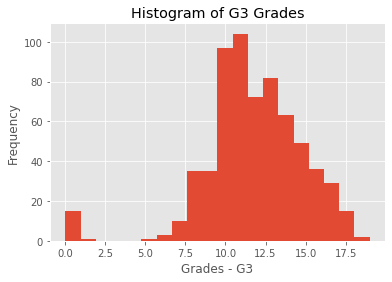

In [12]:
plt.style.use('ggplot')
dataset['G3'].plot.hist(title='Histogram of G3 Grades', bins=20)
plt.xlabel('Grades - G3')

Text(0.5, 0, 'Grades - G2')

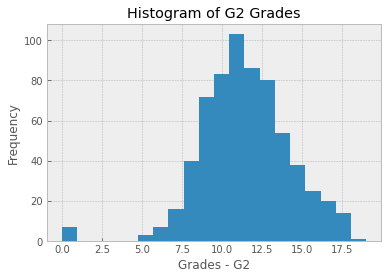

In [13]:
plt.style.use('bmh')
dataset['G2'].plot.hist(title='Histogram of G2 Grades',bins=20)
plt.xlabel('Grades - G2')

Text(0.5, 0, 'Grades - G1')

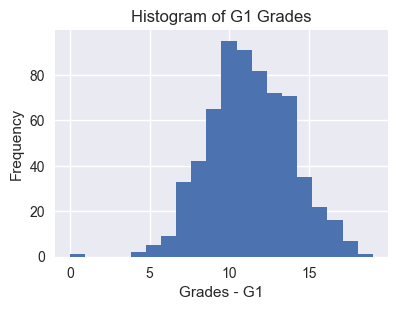

In [14]:
plt.figure(figsize=(4.30,3), dpi=100)
plt.style.use('seaborn')
dataset['G1'].plot.hist(title='Histogram of G1 Grades',bins=20)
plt.xlabel('Grades - G1')

As we can see from the visualisations above, the grades of all students somewhat represent the familiar Gaussian curve, with the mean centred around the scores of 10-12. However, as seen from the final (G3) scores, we have a slightly higher number of students with extremely low scores (around 0-2), indicating a higher failure rate.

### Visualizing the Relationship Between the Number of Absences and G3 Grades

In the research paper by P Cortez (see link in introduction), the researchers stated that certain features are correlated with the final scores. In this section, we briefly check if one of those features, namely the number of absences, is correlated with the final scores.

In [15]:
Absences = dataset.iloc[:, -7].values
G3 = dataset.iloc[:, -4].values

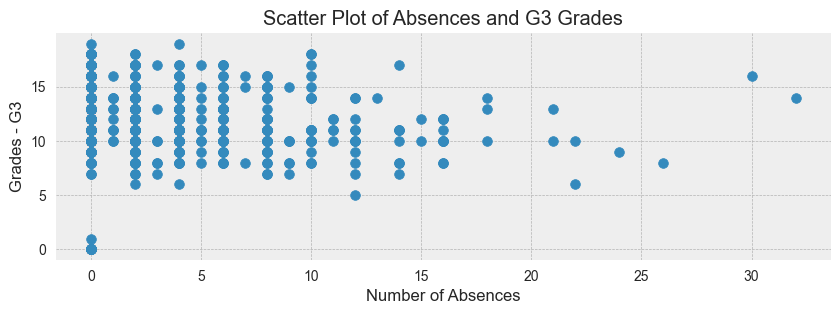

In [16]:
plt.figure(figsize=(10,3), dpi=100)
plt.style.use('bmh')
plt.xlabel('Number of Absences')
plt.ylabel('Grades - G3')
plt.title('Scatter Plot of Absences and G3 Grades')
plt.scatter(Absences,G3)

The scatter plot doesn't indicate the presence of a strong correlation between the grades and the number of absences. For instance, within a pool of students who were never absent, we have those who received high scores (with scores >16) while also having several students who failed (with scores <10). However, we can see there is a weak negative correlation between the grades and the number of absences since the grades tend to fall as the number of absences increases. However, this relationship is fairly weak.



Before we proceed to the modelling phase, we need to perform a few more preliminary steps that are crucial.

## Verifying if there is missing data

In [17]:
dataset.isnull().values.any()

False

## Encoding categorical data

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22])], remainder="passthrough")
X = np.array(ct.fit_transform(X))

In [19]:
print(X)

[[1.0 0.0 1.0 ... 4 0 11]
 [1.0 0.0 1.0 ... 2 9 11]
 [1.0 0.0 1.0 ... 6 12 13]
 ...
 [0.0 1.0 1.0 ... 6 11 12]
 [0.0 1.0 0.0 ... 6 10 10]
 [0.0 1.0 0.0 ... 4 10 11]]


## Splitting the Dataset Into a Training Set and Test Set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [21]:
print(X_train)

[[1.0 0.0 1.0 ... 2 12 12]
 [0.0 1.0 1.0 ... 0 14 13]
 [1.0 0.0 0.0 ... 0 11 11]
 ...
 [1.0 0.0 1.0 ... 2 13 11]
 [1.0 0.0 1.0 ... 12 12 12]
 [1.0 0.0 0.0 ... 4 13 13]]


In [22]:
print(X_test)

[[0.0 1.0 0.0 ... 0 7 0]
 [1.0 0.0 0.0 ... 2 9 10]
 [0.0 1.0 1.0 ... 9 9 8]
 ...
 [0.0 1.0 1.0 ... 0 5 0]
 [1.0 0.0 1.0 ... 2 10 9]
 [0.0 1.0 1.0 ... 0 6 8]]


In [23]:
print(y_train)

[15 13 14 11 11 12 12 11 15 11 13 12 18 13 10 11 16 11 12 15 10 14 13 13
 16  8 15 17 13  8  9 13 13 10  9 13 12 10 12 11 12 14 10 11 10 11 12  7
  8 10 14 17 10 10 17 14 15 18 13 13 10 14 13 13 10 15 11  0 11 16 16 10
 11 14 14 10 14 11 17  0 11 13 14 17 17 12 12 14 11 12 14 15 13 10 15 16
 11  9 15 13  0  9 13 11 13 15 11  8 15  9  9 11 15  7 10 11 15 14  8 13
 16 10 16 17 11 15 10 17  9 14 12  9 13 11 12 10 15 10 14 14 10 12 10 12
  6 13 15 14 10 14 14 13 16 10 17  6 17 12 12 13 13 12  7  8  8 14  8 11
 16 10  9 10 14 11 15 11  9 10 14 11  7 11 14 16 13 12 15 13 11 14 12 13
 10 10 10 14 14  8 11 17 14 10 11 14 13 13 13  0 11 11 11 12 11  8 11 10
 12 14 10 11 10  0  9  0 13 16 11  9 12 15 12 17 16 11  8 16 10  8 14 11
 13 15 15 13 12 17  8  9  7 10 15  9 13 11 18 16 12 10 15 13 15 14  8 13
 10 15 16 10 17 10 13 13 12 11 13  9 13  0 13 15 12 15 10 11 10 14 13 15
 11 14 12 18  9 10 11 12 12  8  8 11 12 15 11 10 15  0 11  8 11  9 13 12
 12 11 14 10 10 11 10 11 12 11 12 11  0 18 10 12 11

In [24]:
print(y_test)

[ 0 11  8  8 11 11 15 13 16 14  9 10  9 14 16 12 10  9 12 11 16  0 10 10
 11  9 13 12 14 11 10 13 10  0 10 11 14 15 18 15 16 11 14 13 12 17 14 18
 10 17 10 18 11 16 18 11  9 10 15 14  9  8 17  9 18 12 15 18 11 15 13 16
 11 11 11 14 16 10 12 10 11 13 14 18  9 16 13 12 10 16 17 13  8 11 15 17
 12 10 10  7  8  9 13 13 12  9 11 12 14 13 10 10 15 13  7 14 13 19 11  1
 14  9 15 11 10 10 11  0 10  9]


In [25]:
#To print the whole array
# with np.printoptions(threshold=np.inf):
#     print(X_test) 

## Model 1: Linear Regression 

The first model is Linear Regression. This model is used to predict the final numeric grade on a scale of 0-20. Linear Regression is based on a linear approach of modelling the relationship between a dependent variable (the final grade) and a set of independent variables (the explanatory variables such as previous grades, number of absences, etc). Specifically, the relationships are modelled using linear predictor functions whose unknown model parameters are estimated using data. 

In [26]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Now that we have fitted our model into the training set, we will now predict the test set, which includes data that is unseen in the eyes of the regressor! 

In [27]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 1.28  0.  ]
 [10.78 11.  ]
 [ 8.64  8.  ]
 [ 7.6   8.  ]
 [11.49 11.  ]
 [10.61 11.  ]
 [14.53 15.  ]
 [12.82 13.  ]
 [15.32 16.  ]
 [14.22 14.  ]
 [ 9.47  9.  ]
 [10.53 10.  ]
 [12.64  9.  ]
 [12.87 14.  ]
 [15.76 16.  ]
 [12.53 12.  ]
 [ 8.79 10.  ]
 [ 9.16  9.  ]
 [12.98 12.  ]
 [11.19 11.  ]
 [15.31 16.  ]
 [ 1.18  0.  ]
 [ 8.73 10.  ]
 [ 9.44 10.  ]
 [11.39 11.  ]
 [ 8.63  9.  ]
 [11.36 13.  ]
 [12.94 12.  ]
 [13.87 14.  ]
 [10.17 11.  ]
 [ 9.41 10.  ]
 [12.72 13.  ]
 [10.45 10.  ]
 [ 7.56  0.  ]
 [ 9.81 10.  ]
 [11.69 11.  ]
 [13.4  14.  ]
 [15.44 15.  ]
 [18.6  18.  ]
 [15.5  15.  ]
 [15.76 16.  ]
 [11.85 11.  ]
 [13.44 14.  ]
 [13.39 13.  ]
 [11.5  12.  ]
 [17.82 17.  ]
 [14.03 14.  ]
 [18.54 18.  ]
 [10.32 10.  ]
 [14.85 17.  ]
 [ 9.94 10.  ]
 [18.04 18.  ]
 [11.65 11.  ]
 [15.74 16.  ]
 [17.66 18.  ]
 [11.21 11.  ]
 [ 8.07  9.  ]
 [11.55 10.  ]
 [13.35 15.  ]
 [14.46 14.  ]
 [10.06  9.  ]
 [ 8.65  8.  ]
 [15.35 17.  ]
 [10.19  9.  ]
 [17.44 18.  ]
 [12.21 12.  ]
 [15.35 15

A brief view of the matrix, where the first column indicates the predictions and the second column the actual scores, shows that our simple LR model does seem fairly accurate as most of our predictions are within 1-2 points from the actual score. We will now use a popular performance metric to test the performance of our model. In particular, we will use the coefficient of determination (which determines how well the regression predictions of our final scores approximate the real data) as a performance metric. 


In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'Score (R2): {r2}')

Score (R2): 0.8571349295671989


The coefficient of determination is 0.85 - with 0 implying no predictive power and 1 implying the best possible score. This means that our model indeed has strong predictive power and that our predictions of the students’ final scores well approximate the actual final scores. 

We will now proceed to applying k-Fold Cross Validation. Using k-Fold Cross Validation allows us to test our model on  ALL of our data, instead of only the test set. It's also a powerful preventative measure against overfitting, and provides a more realistic picture of our model accuracy.

## Applying k-Fold Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10, scoring='r2')
print("Score (R2): {:.2f}".format(scores.mean()))
print("Standard Deviation: {:.2f}".format(scores.std()))

Score (R2): 0.83
Standard Deviation: 0.10


The coefficient of determination is slightly lower at 0.83, indicating there was a slight presence of overfitting in the model. Nevertheless, 0.83 is still a high score when it comes to assessing the predictive power of our model.

## Model 2A: Decision-Tree Based Classification to predict pass/fail

Our second model is a binary classification model that will be used to predict whether a student will pass or fail the final exam. Specifically, we will use a Decision Tree. Decision Tree Algorithms are based on a Decision Tree branching structure, which represents a set of ‘IF-THEN’ rules. At each step, the algorithm verifies if a certain criterion is passed, and if it is passed, it performs a certain operation, with the end goal of predicting a certain outcome (e.g. PASS/FAIL). 

In [30]:
y = dataset.iloc[:, -3].values #Column Pass/Fail

In [31]:
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0
 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 0 1 1 1 0 1 1 0 1 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [33]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [34]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]]


In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[15  9]
 [ 7 99]]


In [36]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy: 87.69 %


## Applying k-Fold Cross Validation

In [37]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 91.14 %
Standard Deviation: 3.24 %


As we can see, we get a pretty high accuracy after applying k-Fold Cross Validation on our model. In other words, our model can predict with 91.14% accuracy that a student will pass or fail their final exam. However, at this point, we can ask ourselves, how can we further optimise our model? The answer is applying Grid Search. Grid search is a method to perform hyper-parameter optimisation, that is, it is a method to find the best combination of hyper-parameters for a given model and test dataset. In the next block of code, we will apply it to find the best model combination along with the best parameters.

## Applying Grid Search to find the best model and the best parameters

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print("Best Parameters:", best_parameters)

Best Accuracy: 92.87 %
Best Parameters: {'criterion': 'entropy', 'max_depth': 4}


Applying GridSearchCV yields an accuracy of 92.87%, along with the parameters of {'criterion': 'entropy', 'max_depth': 4} concerning the decsion tree. 

## Model 2B: Decision-Tree Based Classification to predict encoded  grade

In this section, we will still use a Decision Tree, but instead of predicting whether a student will pass or fail the course, we will use it to predict the student's grade on a scale of 1-5, with 1 being the highest and 5 being the lowest.

In [39]:
y = dataset.iloc[:, -2].values #Column Grade Label Encoded

In [40]:
print(y)

[4 4 3 2 3 3 3 3 1 3 2 3 3 3 2 1 2 2 5 3 2 3 2 4 4 3 3 4 3 3 4 2 2 3 3 4 2
 3 3 3 4 4 2 4 4 4 3 1 3 3 3 1 5 3 3 3 2 1 2 1 1 1 4 3 3 1 3 4 4 2 4 4 4 2
 4 4 4 3 4 4 3 5 4 3 3 3 4 2 4 4 4 3 3 2 3 3 4 3 3 3 5 1 3 4 1 4 4 2 4 2 2
 4 4 1 4 2 1 2 4 2 2 3 3 3 4 5 4 4 2 3 3 5 4 3 3 2 4 4 4 2 4 3 3 4 4 4 4 2
 5 4 5 3 4 3 4 5 3 4 4 3 4 5 4 5 4 3 4 3 5 4 4 4 5 4 5 5 4 5 5 5 4 1 3 1 4
 1 4 3 2 4 2 4 4 3 4 3 1 2 1 2 4 1 2 4 3 3 3 4 3 1 2 3 1 4 2 3 2 3 3 5 3 2
 3 3 3 3 3 4 4 2 4 4 3 3 4 3 2 4 1 5 1 4 4 1 3 3 3 2 5 3 1 4 3 4 4 5 5 5 2
 4 4 3 5 5 4 2 2 2 3 2 2 3 2 4 4 4 1 4 3 5 4 4 5 4 5 3 3 4 3 1 4 4 2 2 3 2
 1 4 3 3 2 4 3 3 3 5 1 2 3 2 4 3 1 3 1 2 1 3 4 3 3 2 4 4 4 4 3 1 3 2 2 3 1
 2 2 1 1 1 1 2 2 3 2 1 1 2 3 5 1 1 4 2 4 4 2 2 1 1 2 1 2 4 3 2 1 1 3 2 4 4
 5 4 3 4 1 2 2 3 1 4 3 2 4 3 4 4 2 2 3 3 2 2 2 2 1 3 1 2 2 1 1 2 3 2 1 4 3
 3 3 2 1 2 1 4 2 4 1 1 2 4 1 4 3 4 3 4 4 1 5 4 4 4 5 2 4 4 5 3 3 1 5 5 2 5
 4 5 4 5 1 3 2 4 4 5 5 5 2 4 3 4 4 2 2 3 4 5 4 2 3 3 3 3 1 4 4 2 5 4 5 4 4
 4 5 4 5 4 4 4 5 4 4 5 4 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [42]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [43]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[5 5]
 [4 4]
 [5 5]
 [5 5]
 [4 4]
 [3 4]
 [1 2]
 [3 3]
 [2 1]
 [2 2]
 [5 5]
 [4 4]
 [2 5]
 [2 2]
 [1 1]
 [3 3]
 [4 4]
 [4 5]
 [3 3]
 [4 4]
 [2 1]
 [4 5]
 [4 4]
 [5 4]
 [4 4]
 [4 5]
 [4 3]
 [3 3]
 [3 2]
 [4 4]
 [4 4]
 [3 3]
 [4 4]
 [5 5]
 [4 4]
 [3 4]
 [2 2]
 [2 2]
 [1 1]
 [2 2]
 [1 1]
 [4 4]
 [3 2]
 [3 3]
 [3 3]
 [1 1]
 [2 2]
 [1 1]
 [4 4]
 [1 1]
 [5 4]
 [1 1]
 [4 4]
 [1 1]
 [1 1]
 [4 4]
 [5 5]
 [4 4]
 [3 2]
 [2 2]
 [4 5]
 [4 5]
 [1 1]
 [4 5]
 [1 1]
 [3 3]
 [1 2]
 [1 1]
 [4 4]
 [2 2]
 [3 3]
 [1 1]
 [4 4]
 [3 4]
 [3 4]
 [2 2]
 [1 1]
 [4 4]
 [3 3]
 [4 4]
 [3 4]
 [3 3]
 [3 2]
 [1 1]
 [5 5]
 [2 1]
 [2 3]
 [3 3]
 [4 4]
 [1 1]
 [1 1]
 [3 3]
 [4 5]
 [4 4]
 [2 2]
 [1 1]
 [3 3]
 [3 4]
 [4 4]
 [5 5]
 [5 5]
 [4 5]
 [3 3]
 [3 3]
 [3 3]
 [5 5]
 [3 4]
 [3 3]
 [3 2]
 [3 3]
 [5 4]
 [4 4]
 [2 2]
 [3 3]
 [5 5]
 [2 2]
 [3 3]
 [1 1]
 [4 4]
 [4 5]
 [2 2]
 [4 5]
 [3 2]
 [5 4]
 [4 4]
 [2 4]
 [3 4]
 [5 5]
 [4 4]
 [4 5]]


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[19  3  0  0  0]
 [ 2 13  6  0  0]
 [ 0  1 21  1  0]
 [ 0  1  8 27  4]
 [ 0  1  0 11 12]]


In [45]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy: 70.77 %


## Applying k-Fold Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 63.96 %
Standard Deviation: 6.75 %


## Applying Grid Search to find the best model and the best parameters

In [47]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print("Best Parameters:", best_parameters)

Best Accuracy: 73.60 %
Best Parameters: {'criterion': 'entropy', 'max_depth': 4}


Applying the same steps as in our previous section yields a best accuracy of 73.60%. This is lower than our binary classification accuracy since our model is now predicting 5 labels instead of 2.

## Model 3A: Random-Forest Classification to predict pass/fail

In this section, we will now apply the Random Forest model. This section will follow a similar structure to the previous section, such that we will use the RF model to perform a binary classification, and later a multi-label classification. A Random Forest is essentially an ensemble of multiple Decision Trees. It establishes the outcome based on the predictions of these decision trees. Specifically, it predicts by taking the average or mean of the output from various trees.

In [48]:
y = dataset.iloc[:, -3].values #Column Pass/Fail

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [50]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [51]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]]


In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

[[ 16   8]
 [  3 103]]
Accuracy: 91.54 %


## Applying k-Fold Cross Validation

In [53]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 92.49 %
Standard Deviation: 2.18 %


Our RF model yields a slightly higher accuracy at 92.49% when it comes to predicting pass/fail compared to our previous decision tree model.

## Model 3B: Random-Forest Classification to predict encoded  grade

In [54]:
y = dataset.iloc[:, -2].values #Column Grade Label Encoded

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [56]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [57]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[5 5]
 [4 4]
 [4 5]
 [4 5]
 [4 4]
 [4 4]
 [1 2]
 [3 3]
 [2 1]
 [1 2]
 [5 5]
 [4 4]
 [2 5]
 [3 2]
 [1 1]
 [3 3]
 [4 4]
 [4 5]
 [3 3]
 [4 4]
 [1 1]
 [5 5]
 [5 4]
 [4 4]
 [4 4]
 [4 5]
 [4 3]
 [3 3]
 [2 2]
 [4 4]
 [4 4]
 [3 3]
 [4 4]
 [5 5]
 [4 4]
 [4 4]
 [3 2]
 [2 2]
 [1 1]
 [2 2]
 [1 1]
 [4 4]
 [3 2]
 [2 3]
 [3 3]
 [1 1]
 [3 2]
 [2 1]
 [4 4]
 [2 1]
 [4 4]
 [1 1]
 [4 4]
 [3 1]
 [1 1]
 [4 4]
 [5 5]
 [4 4]
 [3 2]
 [2 2]
 [4 5]
 [4 5]
 [2 1]
 [4 5]
 [1 1]
 [3 3]
 [1 2]
 [2 1]
 [4 4]
 [1 2]
 [3 3]
 [1 1]
 [4 4]
 [4 4]
 [4 4]
 [3 2]
 [2 1]
 [4 4]
 [3 3]
 [4 4]
 [4 4]
 [3 3]
 [2 2]
 [1 1]
 [5 5]
 [2 1]
 [3 3]
 [2 3]
 [4 4]
 [1 1]
 [1 1]
 [2 3]
 [4 5]
 [4 4]
 [2 2]
 [2 1]
 [3 3]
 [4 4]
 [4 4]
 [4 5]
 [5 5]
 [4 5]
 [3 3]
 [3 3]
 [3 3]
 [4 5]
 [3 4]
 [3 3]
 [2 2]
 [2 3]
 [4 4]
 [5 4]
 [1 2]
 [3 3]
 [4 5]
 [2 2]
 [3 3]
 [1 1]
 [4 4]
 [4 5]
 [2 2]
 [4 5]
 [2 2]
 [4 4]
 [4 4]
 [2 4]
 [4 4]
 [5 5]
 [4 4]
 [5 5]]


In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

[[13  8  1  0  0]
 [ 5 10  6  0  0]
 [ 0  4 18  1  0]
 [ 0  1  1 36  2]
 [ 0  1  0 14  9]]
Accuracy: 66.15 %


## Applying k-Fold Cross Validation

In [59]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 63.79 %
Standard Deviation: 6.60 %


After k-Fold Cross Validation, we see an accuracy of 63.79%. This is a lot lower than our previous model. Therefore, we will now apply a hyper-parameter optimisation method to see if we can get a higher accuracy. Instead of GridSearchCV, will now use Random Search CV. According to the sklearn documentations, the parameters of the estimator used to apply these methods are optimised by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. In general, the only difference between both the approaches is in grid search we define the combinations and do training of the model whereas in RandomizedSearchCV the model selects the combinations randomly. Both are very effective ways of tuning the parameters that increase the model generalisability. 

## Random Search Cross Validation in Scikit-Learn

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [61]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [62]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [63]:
y_pred = rf_random.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[5 5]
 [4 4]
 [5 5]
 [5 5]
 [4 4]
 [4 4]
 [2 2]
 [3 3]
 [2 1]
 [2 2]
 [4 5]
 [4 4]
 [3 5]
 [3 2]
 [1 1]
 [3 3]
 [4 4]
 [4 5]
 [3 3]
 [4 4]
 [1 1]
 [5 5]
 [5 4]
 [4 4]
 [4 4]
 [4 5]
 [4 3]
 [3 3]
 [3 2]
 [4 4]
 [4 4]
 [3 3]
 [4 4]
 [5 5]
 [4 4]
 [4 4]
 [3 2]
 [2 2]
 [1 1]
 [2 2]
 [1 1]
 [4 4]
 [3 2]
 [3 3]
 [4 3]
 [1 1]
 [2 2]
 [1 1]
 [4 4]
 [2 1]
 [4 4]
 [1 1]
 [4 4]
 [1 1]
 [1 1]
 [4 4]
 [5 5]
 [4 4]
 [3 2]
 [2 2]
 [4 5]
 [4 5]
 [2 1]
 [5 5]
 [1 1]
 [3 3]
 [1 2]
 [1 1]
 [4 4]
 [2 2]
 [3 3]
 [1 1]
 [4 4]
 [4 4]
 [4 4]
 [3 2]
 [1 1]
 [4 4]
 [3 3]
 [4 4]
 [4 4]
 [3 3]
 [3 2]
 [1 1]
 [5 5]
 [2 1]
 [3 3]
 [3 3]
 [4 4]
 [1 1]
 [1 1]
 [3 3]
 [4 5]
 [4 4]
 [2 2]
 [1 1]
 [3 3]
 [4 4]
 [4 4]
 [5 5]
 [5 5]
 [4 5]
 [3 3]
 [4 3]
 [3 3]
 [4 5]
 [4 4]
 [3 3]
 [2 2]
 [3 3]
 [4 4]
 [4 4]
 [1 2]
 [3 3]
 [5 5]
 [2 2]
 [3 3]
 [1 1]
 [4 4]
 [4 5]
 [3 2]
 [4 5]
 [2 2]
 [4 4]
 [4 4]
 [3 4]
 [4 4]
 [5 5]
 [4 4]
 [5 5]]


In [64]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)* 100))

[[18  4  0  0  0]
 [ 2 11  8  0  0]
 [ 0  0 20  3  0]
 [ 0  0  1 38  1]
 [ 0  0  1 10 13]]
Accuracy: 76.92 %


As expected, after implementing RandomSearchCV, we get a higher accuracy at 76.15%, which is slightly higher than the one yielded by the Decision Tree model.

## Model 4A: XGboost to predict pass/fail

Our final model will involve the implementation of the famous XGboost library. XGBoost is an optimised distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosted trees framework. Gradient Boosted Trees act similarly to Random Forests, in the sense that they are based on an ensemble of decision trees. However, what distinguishes them is the fact that the learner trees are trained sequentially where the “weak” learner trees are combined in some way to get a “stronger” classifier (with a higher predictive power).



In [65]:
y = dataset.iloc[:, -3].values #Column Pass/Fail
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [66]:
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier
classifier = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
classifier.fit(X_train, y_train)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [67]:
y_pred = classifier.predict(X_test)

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

[[ 14  10]
 [  3 103]]
Accuracy: 90.00 %


## Applying k-Fold Cross Validation

In [69]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 92.29 %
Standard Deviation: 2.85 %


The accuracy yielded from the binary level classification is comparable to our other models, at approximately 92.29%. 

## Model 4B: XGboost to predict encoded  grade

In [70]:
y = dataset.iloc[:, -2].values #Column Grade Label Encoded

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [72]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

[13:56:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
y_pred = classifier.predict(X_test)

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

[[20  2  0  0  0]
 [ 1 14  6  0  0]
 [ 0  0 21  2  0]
 [ 0  0  4 34  2]
 [ 0  0  1  9 14]]
Accuracy: 79.23 %


## Applying k-Fold Cross Validation

In [75]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[13:56:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 70.90 %
Standard Deviation: 6.03 %


Before we applied k-Fold Cross Validation, our multi-label accuracy was around 79%. However, this number dropped after we performed cross-validation, indicating the presence of overfitting. To further improve our model performance, we explored several options from GridSearchCV to RandomSearchCV. However, both options took way too much computational time which is why we decided to explore data augmentation techniques to tackle class imbalance. A quick look at the data visualisations before shows that most of the grades were concentrated around the mean, with higher instances of grades around C or D (3 or 4). As such, we turn to SMOTE or Synthetic Minority Over-Sampling Technique, which is an oversampling technique designed to increase the samples of the minority class. This approach is effective because new synthetic examples from the minority class are created that are plausible, that is, that are relatively close in the feature space to existing examples from the minority class. We will first import SMOTE from the imblearn.over_sampling library and perform the usual steps and compare the final results on the new set of data.

## Using SMOTE to mitigate the effects of unbalanced classes 

In [76]:
!{sys.executable} -m pip install imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = 'auto', random_state=27)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train) #It's important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.
#Let's now fit our classifiers over our updated dataset!

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


In [77]:
assert len(X_train_smote) !=  len(X_train)
assert len(y_train_smote) != len(y_train) #confirming that we have a resampled dataset with synthetic values

In [78]:
smote_xgb = classifier.fit(X_train_smote, y_train_smote)
smote_pred_xg = smote_xgb.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [79]:
cm_slr = confusion_matrix(y_test, smote_pred_xg)

In [80]:
print(cm_slr)

[[19  3  0  0  0]
 [ 1 14  6  0  0]
 [ 0  2 20  1  0]
 [ 0  0  3 34  3]
 [ 0  0  1  8 15]]


In [81]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, smote_pred_xg)*100))

Accuracy: 78.46 %



Comparing our accuracy with the original XGBoost model post k-Fold Cross Validation, we notice a significant improvement in the accuracy, which now stands at 78.46%.

## Applying k-Fold Cross Validation

In [82]:
accuracies = cross_val_score(estimator = classifier, X = X_train_smote, y = y_train_smote, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[13:57:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 80.67 %
Standard Deviation: 8.66 %


After applying Cross Validation to the modified data, we get an average accuracy of 80.7%, which is the highest we have seen so far. We will now summarise all the accuracies from all of our classification models in the bar chart below.

In [83]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

Text(0.5, 1.0, 'Model Comparison - Classification')

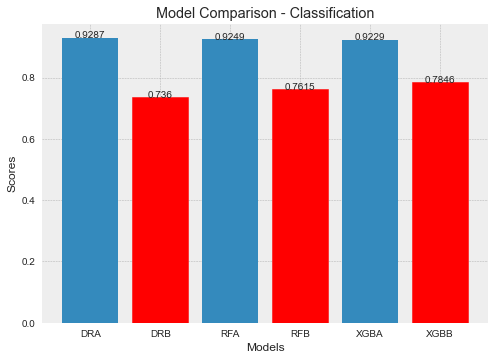

In [84]:
Models = ['DRA', 'DRB','RFA', 'RFB', 'XGBA', 'XGBB']
Scores = [0.9287, 0.7360, 0.9249, 0.7615, 0.9229, 0.8067]
barlist = plt.bar(Models, Scores)
addlabels(Models, Scores)
for i in range(1,6,2):
    barlist[i].set_color('r')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison - Classification')
